In [1]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, make_scorer, average_precision_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn import preprocessing
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot  as plt
from sklearn.model_selection import KFold
from collections import defaultdict

In [2]:
#read lables
data = pd.read_csv("/home/databank/zlp/md-40/DTI_prediction/all_labels_features.csv", header=0)
print(data.shape)
data.head()

(6615, 34)


,File,pocket name,pdb id,ligand name,ligand smiles,labels,hydrophobicity,aliphatic,aromatic,sulfur,...,stability_std,stability_3A_mean,stability_3A_std,ligand_erg,ligand_ecfp4,ligand_ecfp6,ligand_rdkit2d,ligand_daylight,ligand_pubchem,ligand_maccs
0,1952-3tic,P01,3TIC,ZMR,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)CO)OC(C(=O)...,1,-1.60,0.30,0.08,0.00,...,0.31,0.55,0.31,0.8999999999999999_3.9_4.499999999999999_4.699...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.9831924029824667_0.10249789678512451_0.35731...,1.0_1.0_1.0_1.0_0.0_1.0_0.0_0.0_1.0_0.0_0.0_0....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_1_1_1_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....
1,1952-3tic,P02,3TIC,ZMR,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)CO)OC(C(=O)...,0,-2.02,0.27,0.20,0.00,...,0.28,0.39,0.29,0.8999999999999999_3.9_4.499999999999999_4.699...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.9831924029824667_0.10249789678512451_0.35731...,1.0_1.0_1.0_1.0_0.0_1.0_0.0_0.0_1.0_0.0_0.0_0....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_1_1_1_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....
2,1952-3tic,P03,3TIC,ZMR,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)CO)OC(C(=O)...,0,-1.03,0.30,0.20,0.00,...,0.17,0.25,0.17,0.8999999999999999_3.9_4.499999999999999_4.699...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.9831924029824667_0.10249789678512451_0.35731...,1.0_1.0_1.0_1.0_0.0_1.0_0.0_0.0_1.0_0.0_0.0_0....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_1_1_1_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....
3,1952-3tic,P04,3TIC,ZMR,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)CO)OC(C(=O)...,0,-1.82,0.30,0.30,0.00,...,0.21,0.35,0.23,0.8999999999999999_3.9_4.499999999999999_4.699...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.9831924029824667_0.10249789678512451_0.35731...,1.0_1.0_1.0_1.0_0.0_1.0_0.0_0.0_1.0_0.0_0.0_0....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_1_1_1_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....
4,1952-3tic,P05,3TIC,ZMR,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)CO)OC(C(=O)...,0,-0.22,0.17,0.17,0.17,...,0.19,0.40,0.20,0.8999999999999999_3.9_4.499999999999999_4.699...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.9831924029824667_0.10249789678512451_0.35731...,1.0_1.0_1.0_1.0_0.0_1.0_0.0_0.0_1.0_0.0_0.0_0....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_1_1_1_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....


In [47]:
data['hydrophobicity'].min(),data['hydrophobicity'].max()

(-3.31, 2.21)

In [4]:
data[(data['File'] == "1hwk") & (data["labels"] == 1)]

,File,pocket name,pdb id,ligand name,ligand smiles,labels,hydrophobicity,aliphatic,aromatic,sulfur,...,stability_std,stability_3A_mean,stability_3A_std,ligand_erg,ligand_ecfp4,ligand_ecfp6,ligand_rdkit2d,ligand_daylight,ligand_pubchem,ligand_maccs
15,1hwk,P01,2R4F,RIE,CC(C)c1c(C(=O)N(C)[C@H](C)c2ccccc2)nn(-c2ccc(F...,1,-0.36,0.42,0.02,0.1,...,0.28,0.69,0.30,0.0_0.0_0.6_2.0_0.8999999999999999_1.0_0.3_0.0...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.7428613583973158_0.7557182548744535_0.892296...,1.0_0.0_0.0_0.0_0.0_1.0_1.0_0.0_1.0_1.0_1.0_1....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_1_0_0_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....
16,1hwk,P02,2R4F,RIE,CC(C)c1c(C(=O)N(C)[C@H](C)c2ccccc2)nn(-c2ccc(F...,1,-0.24,0.43,0.03,0.1,...,0.30,0.71,0.32,0.0_0.0_0.6_2.0_0.8999999999999999_1.0_0.3_0.0...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.7428613583973158_0.7557182548744535_0.892296...,1.0_0.0_0.0_0.0_0.0_1.0_1.0_0.0_1.0_1.0_1.0_1....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_1_0_0_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....
25,1hwk,P01,2Q6C,HR1,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2ccc...,1,-0.36,0.42,0.02,0.1,...,0.28,0.69,0.30,0.0_0.0_0.6_2.0_0.8999999999999999_1.0_0.3_0.0...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.5850233629804753_0.9670881697222502_0.915185...,1.0_1.0_1.0_1.0_1.0_1.0_1.0_0.0_1.0_1.0_0.0_1....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_0_0_0_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....
26,1hwk,P02,2Q6C,HR1,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2ccc...,1,-0.24,0.43,0.03,0.1,...,0.30,0.71,0.32,0.0_0.0_0.6_2.0_0.8999999999999999_1.0_0.3_0.0...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.5850233629804753_0.9670881697222502_0.915185...,1.0_1.0_1.0_1.0_1.0_1.0_1.0_0.0_1.0_1.0_0.0_1....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_0_0_0_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....
35,1hwk,P01,3CCZ,5HI,CC(C)c1c(C(=O)N[C@H](CO)c2ccccc2)nc(-c2ccc(F)c...,1,-0.36,0.42,0.02,0.1,...,0.28,0.69,0.30,0.0_0.3_1.6_2.3_0.8999999999999999_1.0_0.6_1.0...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.723680490636476_0.7454824764216719_0.8889212...,1.0_1.0_0.0_1.0_1.0_1.0_0.0_1.0_1.0_1.0_1.0_1....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_1_0_0_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....
36,1hwk,P02,3CCZ,5HI,CC(C)c1c(C(=O)N[C@H](CO)c2ccccc2)nc(-c2ccc(F)c...,1,-0.24,0.43,0.03,0.1,...,0.30,0.71,0.32,0.0_0.3_1.6_2.3_0.8999999999999999_1.0_0.6_1.0...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.723680490636476_0.7454824764216719_0.8889212...,1.0_1.0_0.0_1.0_1.0_1.0_0.0_1.0_1.0_1.0_1.0_1....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_1_0_0_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....
45,1hwk,P01,1HWK,117,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,1,-0.36,0.42,0.02,0.1,...,0.28,0.69,0.30,0.0_0.0_0.6_2.0_0.8999999999999999_1.0_0.6_1.0...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.6737667846375862_0.891694206235105_0.9191603...,1.0_1.0_0.0_1.0_1.0_1.0_0.0_1.0_1.0_1.0_1.0_1....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_1_0_0_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....
46,1hwk,P02,1HWK,117,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,1,-0.24,0.43,0.03,0.1,...,0.30,0.71,0.32,0.0_0.0_0.6_2.0_0.8999999999999999_1.0_0.6_1.0...,0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.0_1.0_0.0_0.0_1.0_0.0_0.0_0.0_0.0_0.0_0.0_0....,0.6737667846375862_0.891694206235105_0.9191603...,1.0_1.0_0.0_1.0_1.0_1.0_0.0_1.0_1.0_1.0_1.0_1....,0_0_0_0_0_0_0_0_0_1_1_1_0_0_1_0_0_0_1_1_1_0_0_...,0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0.0_0....
55,1hwk,P01,2Q1L,882,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC(=O

prepare traning validation and test dataset

In [3]:
ligand_ecfp4_fp = data["ligand_ecfp4"].str.split("_", expand=True).astype(float)
ligand_ecfp4_fp.columns = ["ligand_ecfp4_"+ str(i) for i in range(ligand_ecfp4_fp.shape[1])]
df = pd.concat([data, ligand_ecfp4_fp], axis=1)

df_train_val = df.drop(index=df[(df["File"] == "1hwk") | (df["File"] == "1zuc") | (df["File"] == "ppar-gamma")].index.values)
df_test = df[(df["File"] == "1kvl") | (df["File"] == "1z95") | (df["File"] == "fkbp5")]
df_train_val.shape, df_test.shape

((6020, 1058), (476, 1058))

In [5]:
ligand_ecfp4_fp.head()

,ligand_ecfp4_0,ligand_ecfp4_1,ligand_ecfp4_2,ligand_ecfp4_3,ligand_ecfp4_4,ligand_ecfp4_5,ligand_ecfp4_6,ligand_ecfp4_7,ligand_ecfp4_8,ligand_ecfp4_9,...,ligand_ecfp4_1014,ligand_ecfp4_1015,ligand_ecfp4_1016,ligand_ecfp4_1017,ligand_ecfp4_1018,ligand_ecfp4_1019,ligand_ecfp4_1020,ligand_ecfp4_1021,ligand_ecfp4_1022,ligand_ecfp4_1023
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


using best parameters to train models and evaluation

In [5]:
best_parameters = {"ecfp4":{'max_depth': 2, 'n_estimators': 20, 'learning_rate':0.1, 'subsample':0.5, 'gamma':0, 'min_child_weight':5}}

In [6]:
# best_parameters = {"ecfp4":{'max_depth': 2, 'n_estimators': 20, 'learning_rate':0.1, 'subsample':0.5, 'gamma':0, 'min_child_weight':5}}

ligand_fp_names = ["ecfp4"]
for fp in ligand_fp_names:
    
    features = ['hydrophobicity', 'aliphatic', 'aromatic', 'sulfur',
        'hydroxyl', 'basic', 'acidic', 'amide', 'polar', 'ionizable',
        'hb_donor', 'hb_acceptor', 'hb_donor_acceptor', 'volume', 'depth', 'sa',
        'enclosure', 'stability_mean', 'stability_std'] + list(vars()["ligand_"+fp+"_fp"].columns)
    
    X_train = df_train_val[features]
    y_train = df_train_val["labels"]
    
    sampling = SMOTE(random_state=111)
    X_train_, y_train_ = sampling.fit_resample(X_train, y_train)

    model = XGBClassifier(objective='binary:logistic', seed=0, eval_metric="logloss", **best_parameters[fp])
    model.fit(X_train_, y_train_)
    #save model
    f = open('/home/databank/zlp/md-40/DTI_prediction/xgboost_model/xgboost_'+fp+'.pickle','wb')
    pickle.dump(model,f)
    f.close()

In [7]:
#load model
f = open('/home/databank/zlp/md-40/DTI_prediction/xgboost_model/xgboost_ecfp4.pickle','rb')
xgboost_ecfp4 = pickle.load(f)
f.close()

ligand_fp_names = ["ecfp4"]
for fp in ligand_fp_names:
    
    features = ['hydrophobicity', 'aliphatic', 'aromatic', 'sulfur',
        'hydroxyl', 'basic', 'acidic', 'amide', 'polar', 'ionizable',
        'hb_donor', 'hb_acceptor', 'hb_donor_acceptor', 'volume', 'depth', 'sa',
        'enclosure', 'stability_mean', 'stability_std'] + list(vars()["ligand_"+fp+"_fp"].columns)
    
    df_test = df_test.reset_index(drop=True)
    X_test = df_test[features]
    y_test = df_test["labels"]

    print("------------------------------------with stability features-------------------------------------------------------")
    print("using ligand fingerprint:",fp)
    model = vars()["xgboost_"+fp]
   
    print("evaluation on test data")
    y_test_pred = model.predict(X_test)
    print("accuracy in test:",np.round(accuracy_score(y_test, y_test_pred),2))
    print("f1 score in test:",np.round(f1_score(y_test, y_test_pred),2))
    print("positive recall score in test:",np.round(recall_score(y_test, y_test_pred, pos_label=1),2))
    print("negative recall score in test:",np.round(recall_score(y_test, y_test_pred, pos_label=0),2))
    print("positive precision score in test:",np.round(precision_score(y_test, y_test_pred, pos_label=1),2))
    print("negative precision score in test:",np.round(precision_score(y_test, y_test_pred, pos_label=0),2))
    print("roc auc score in test:",np.round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),2))
    print("average precision score in validation:",np.round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1]),2))

    #save prediction probality to csv
    y_test_pred_proba = model.predict_proba(X_test)
    test_prediction_results = pd.concat([df_test.iloc[:,:6],pd.DataFrame(y_test_pred_proba, columns=["0_pred_probability", "1_pred_probability"])], axis=1)
    test_prediction_results.to_csv("/home/databank/zlp/md-40/DTI_prediction/xgboost_model/"+"xgboost_"+fp+"_test_prediction_results.csv", header=True, index=False)

------------------------------------with stability features-------------------------------------------------------
using ligand fingerprint: ecfp4
evaluation on test data
accuracy in test: 0.97
f1 score in test: 0.91
positive recall score in test: 0.92
negative recall score in test: 0.98
positive precision score in test: 0.9
negative precision score in test: 0.99
roc auc score in test: 0.98
average precision score in validation: 0.92


In [17]:
#feature importance
features = ['hydrophobicity', 'aliphatic', 'aromatic', 'sulfur',
        'hydroxyl', 'basic', 'acidic', 'amide', 'polar', 'ionizable',
        'hb_donor', 'hb_acceptor', 'hb_donor_acceptor', 'volume', 'depth', 'sa',
        'enclosure', 'stability_mean', 'stability_std'] + list(ligand_ecfp4_fp.columns)
lig_fp_importance = 0
for i in (zip(features, xgboost_ecfp4.feature_importances_*100)):
    if "ecfp4" in i[0]:
        lig_fp_importance += i[1]
    else:
        print(i)
print(("ligand fingerprint importance (ecfp4)", lig_fp_importance))

('hydrophobicity', 7.1874022)
('aliphatic', 0.0)
('aromatic', 6.215123)
('sulfur', 0.0)
('hydroxyl', 4.8073716)
('basic', 0.0)
('acidic', 0.0)
('amide', 0.0)
('polar', 0.0)
('ionizable', 0.0)
('hb_donor', 14.69889)
('hb_acceptor', 0.0)
('hb_donor_acceptor', 0.0)
('volume', 2.4277887)
('depth', 9.981711)
('sa', 27.937294)
('enclosure', 0.0)
('stability_mean', 7.8665404)
('stability_std', 0.0)
('ligand fingerprint importance (ecfp4)', 18.877874612808228)


train model without stability and volume features and evaluation

In [8]:
#without stability
import warnings
warnings.filterwarnings("ignore")

ligand_fp_names = ["ecfp4"]
for fp in ligand_fp_names:
    
    features = ['hydrophobicity', 'aliphatic', 'aromatic', 'sulfur',
        'hydroxyl', 'basic', 'acidic', 'amide', 'polar', 'ionizable',
        'hb_donor', 'hb_acceptor', 'hb_donor_acceptor', 'volume', 'depth', 'sa',
        'enclosure'] + list(vars()["ligand_"+fp+"_fp"].columns)
    
    X_train = df_train_val[features]
    y_train = df_train_val["labels"]
    X_test = df_test[features]
    y_test = df_test["labels"]
    
    sampling = SMOTE(random_state=111)
    X_train_, y_train_ = sampling.fit_resample(X_train, y_train)

    model = XGBClassifier(objective='binary:logistic', seed=0, eval_metric="logloss", **best_parameters[fp])
    model.fit(X_train_, y_train_)
    #save model
    f = open('/home/databank/zlp/md-40/DTI_prediction/xgboost_model/xgboost_'+fp+'_without_stability.pickle','wb')
    pickle.dump(model,f)
    f.close()

    print("------------------------------------without stability features-------------------------------------------------------")
    print("using ligand fingerprint:",fp)
    print("evaluation on test data")
    y_test_pred = model.predict(X_test)
    print("accuracy in test:",np.round(accuracy_score(y_test, y_test_pred),2))
    print("f1 score in test:",np.round(f1_score(y_test, y_test_pred),2))
    print("positive recall score in test:",np.round(recall_score(y_test, y_test_pred, pos_label=1),2))
    print("negative recall score in test:",np.round(recall_score(y_test, y_test_pred, pos_label=0),2))
    print("positive precision score in test:",np.round(precision_score(y_test, y_test_pred, pos_label=1),2))
    print("negative precision score in test:",np.round(precision_score(y_test, y_test_pred, pos_label=0),2))
    print("roc auc score in test:",np.round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),2))
    print("average precision score in validation:",np.round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1]),2))


------------------------------------without stability features-------------------------------------------------------
using ligand fingerprint: ecfp4
evaluation on test data
accuracy in test: 0.95
f1 score in test: 0.85
positive recall score in test: 0.97
negative recall score in test: 0.95
positive precision score in test: 0.75
negative precision score in test: 0.99
roc auc score in test: 0.99
average precision score in validation: 0.9


In [10]:
#without volume
import warnings
warnings.filterwarnings("ignore")

ligand_fp_names = ["ecfp4"]
for fp in ligand_fp_names:
    
    features = ['hydrophobicity', 'aliphatic', 'aromatic', 'sulfur',
        'hydroxyl', 'basic', 'acidic', 'amide', 'polar', 'ionizable',
        'hb_donor', 'hb_acceptor', 'hb_donor_acceptor', 'depth', 'sa',
        'enclosure','stability_mean', 'stability_std'] + list(vars()["ligand_"+fp+"_fp"].columns)
    
    X_train = df_train_val[features]
    y_train = df_train_val["labels"]
    X_test = df_test[features]
    y_test = df_test["labels"]
    
    sampling = SMOTE(random_state=111)
    X_train_, y_train_ = sampling.fit_resample(X_train, y_train)

    model = XGBClassifier(objective='binary:logistic', seed=0, eval_metric="logloss", **best_parameters[fp])
    model.fit(X_train_, y_train_)
    #save model
    f = open('/home/databank/zlp/md-40/DTI_prediction/xgboost_model/xgboost_'+fp+'_without_volume.pickle','wb')
    pickle.dump(model,f)
    f.close()

    print("------------------------------------without volume features-------------------------------------------------------")
    print("using ligand fingerprint:",fp)
    print("evaluation on test data")
    y_test_pred = model.predict(X_test)
    print("accuracy in test:",np.round(accuracy_score(y_test, y_test_pred),2))
    print("f1 score in test:",np.round(f1_score(y_test, y_test_pred),2))
    print("positive recall score in test:",np.round(recall_score(y_test, y_test_pred, pos_label=1),2))
    print("negative recall score in test:",np.round(recall_score(y_test, y_test_pred, pos_label=0),2))
    print("positive precision score in test:",np.round(precision_score(y_test, y_test_pred, pos_label=1),2))
    print("negative precision score in test:",np.round(precision_score(y_test, y_test_pred, pos_label=0),2))
    print("roc auc score in test:",np.round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),2))
    print("average precision score in validation:",np.round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1]),2))

------------------------------------without volume features-------------------------------------------------------
using ligand fingerprint: ecfp4
evaluation on test data
accuracy in test: 0.95
f1 score in test: 0.83
positive recall score in test: 0.97
negative recall score in test: 0.94
positive precision score in test: 0.73
negative precision score in test: 0.99
roc auc score in test: 0.98
average precision score in validation: 0.91


In [11]:
#without stability and volume
import warnings
warnings.filterwarnings("ignore")

ligand_fp_names = ["ecfp4"]
for fp in ligand_fp_names:
    
    features = ['hydrophobicity', 'aliphatic', 'aromatic', 'sulfur',
        'hydroxyl', 'basic', 'acidic', 'amide', 'polar', 'ionizable',
        'hb_donor', 'hb_acceptor', 'hb_donor_acceptor', 'depth', 'sa',
        'enclosure'] + list(vars()["ligand_"+fp+"_fp"].columns)
    
    X_train = df_train_val[features]
    y_train = df_train_val["labels"]
    X_test = df_test[features]
    y_test = df_test["labels"]
    
    sampling = SMOTE(random_state=111)
    X_train_, y_train_ = sampling.fit_resample(X_train, y_train)

    model = XGBClassifier(objective='binary:logistic', seed=0, eval_metric="logloss", **best_parameters[fp])
    model.fit(X_train_, y_train_)
    #save model
    f = open('/home/databank/zlp/md-40/DTI_prediction/xgboost_model/xgboost_'+fp+'_without_stability_volume.pickle','wb')
    pickle.dump(model,f)
    f.close()

    print("------------------------------------without stability and volume features-------------------------------------------------------")
    print("using ligand fingerprint:",fp)
    print("evaluation on test data")
    y_test_pred = model.predict(X_test)
    print("accuracy in test:",np.round(accuracy_score(y_test, y_test_pred),2))
    print("f1 score in test:",np.round(f1_score(y_test, y_test_pred),2))
    print("positive recall score in test:",np.round(recall_score(y_test, y_test_pred, pos_label=1),2))
    print("negative recall score in test:",np.round(recall_score(y_test, y_test_pred, pos_label=0),2))
    print("positive precision score in test:",np.round(precision_score(y_test, y_test_pred, pos_label=1),2))
    print("negative precision score in test:",np.round(precision_score(y_test, y_test_pred, pos_label=0),2))
    print("roc auc score in test:",np.round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),2))
    print("average precision score in validation:",np.round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1]),2))

------------------------------------without stability and volume features-------------------------------------------------------
using ligand fingerprint: ecfp4
evaluation on test data
accuracy in test: 0.95
f1 score in test: 0.85
positive recall score in test: 0.97
negative recall score in test: 0.95
positive precision score in test: 0.75
negative precision score in test: 0.99
roc auc score in test: 0.99
average precision score in validation: 0.9


In [7]:
#load model and predict on test set
f = open('/home/databank/zlp/md-40/DTI_prediction/xgboost_model/xgboost_ecfp4.pickle','rb')
xgboost_ecfp4 = pickle.load(f)
f.close()
features = ['hydrophobicity', 'aliphatic', 'aromatic', 'sulfur',
        'hydroxyl', 'basic', 'acidic', 'amide', 'polar', 'ionizable',
        'hb_donor', 'hb_acceptor', 'hb_donor_acceptor', 'volume', 'depth', 'sa',
        'enclosure','stability_mean', 'stability_std'] + list(vars()["ligand_ecfp4_fp"].columns)
    
X_test = df_test[features]
y_test = df_test["labels"]
y_test_pred_proba = xgboost_ecfp4.predict_proba(X_test)

f = open('/home/databank/zlp/md-40/DTI_prediction/xgboost_model/xgboost_ecfp4_without_stability.pickle','rb')
xgboost_ecfp4_without_sta = pickle.load(f)
f.close()
features = ['hydrophobicity', 'aliphatic', 'aromatic', 'sulfur',
        'hydroxyl', 'basic', 'acidic', 'amide', 'polar', 'ionizable',
        'hb_donor', 'hb_acceptor', 'hb_donor_acceptor', 'volume', 'depth', 'sa',
        'enclosure'] + list(vars()["ligand_ecfp4_fp"].columns)
    
X_test = df_test[features]
y_test = df_test["labels"]
y_test_pred_proba_without_sta = xgboost_ecfp4_without_sta.predict_proba(X_test)

0.9840726183791878
0.9861688190155343


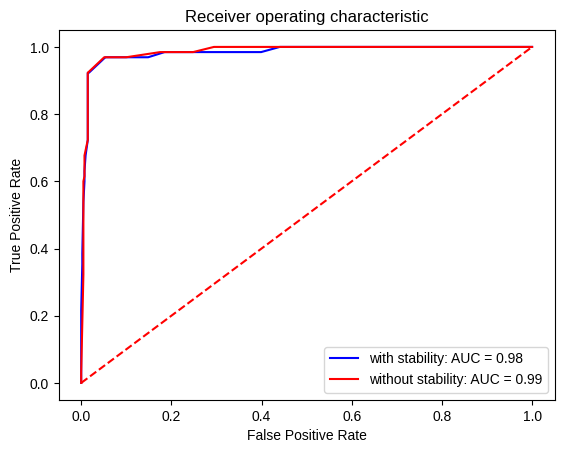

In [10]:
#plot AUC curve
from sklearn import metrics
import matplotlib.pylab as plt

plt.rcParams['font.sans-serif']=["Liberation Sans"]

fpr1, tpr1, thresholds = metrics.roc_curve(y_test, pd.DataFrame(y_test_pred_proba[:,1]))
roc_auc1 = metrics.auc(fpr1, tpr1)  # the value of roc_auc1
print(roc_auc1)
plt.plot(fpr1, tpr1, 'b', label='with stability: AUC = %0.2f' % roc_auc1)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++

fpr2, tpr2, _ = metrics.roc_curve(y_test, pd.DataFrame(y_test_pred_proba_without_sta[:,1]))
roc_auc2 = metrics.auc(fpr2, tpr2)  # the value of roc_auc1
print(roc_auc2)
plt.plot(fpr2, tpr2, 'r', label='without stability: AUC = %0.2f' % roc_auc2)

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
# plt.xlim([0, 1])  # the range of x-axis
# plt.ylim([0, 1])  # the range of y-axis
plt.xlabel('False Positive Rate')  # the name of x-axis
plt.ylabel('True Positive Rate')  # the name of y-axis
plt.title('Receiver operating characteristic')  # the title of figure
plt.show()


0.9268692803514733
0.9148902256483212


/tmp/ipykernel_139766/3859850546.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([1, 0], 'r--', color='b')


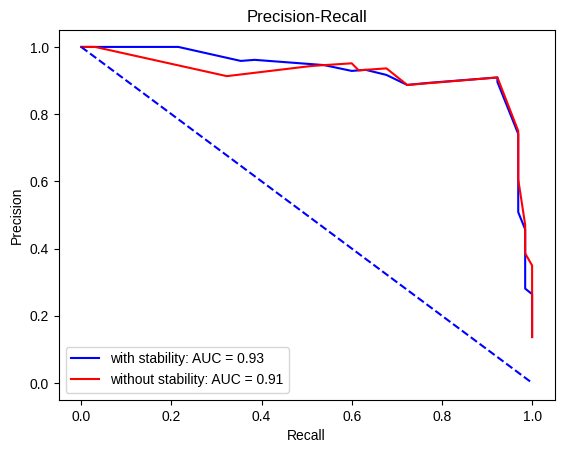

In [9]:
#plot AUPRC curve
from sklearn import metrics
import matplotlib.pylab as plt

plt.rcParams['font.sans-serif']=["Liberation Sans"]

precision1, recall1, _ = metrics.precision_recall_curve(y_test, pd.DataFrame(y_test_pred_proba[:,1]))
aupr1 = metrics.auc(recall1, precision1)  # the value of roc_auc1
print(aupr1)
plt.plot(recall1, precision1, 'b', label='with stability: AUC = %0.2f' % aupr1)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++

precision2, reacall2, _ = metrics.precision_recall_curve(y_test, pd.DataFrame(y_test_pred_proba_without_sta[:,1]))
aupr2 = metrics.auc(reacall2, precision2)  # the value of roc_auc1
print(aupr2)
plt.plot(reacall2, precision2, 'r', label='without stability: AUC = %0.2f' % aupr2)

plt.legend(loc='lower left')
plt.plot([1, 0], 'r--', color='b')
# plt.xlim([0, 1])  # the range of x-axis
# plt.ylim([0, 1])  # the range of y-axis
plt.xlabel('Recall')  # the name of x-axis
plt.ylabel('Precision')  # the name of y-axis
plt.title('Precision-Recall')  # the title of figure
plt.show()

In [12]:
from sklearn.decomposition import PCA
features = ['hydrophobicity', 'aliphatic', 'aromatic', 'sulfur',
        'hydroxyl', 'basic', 'acidic', 'amide', 'polar', 'ionizable',
        'hb_donor', 'hb_acceptor', 'hb_donor_acceptor', 'volume', 'depth', 'sa',
        'enclosure','stability_mean', 'stability_std'] + list(vars()["ligand_ecfp4_fp"].columns)
X_train_pca = PCA(2).fit_transform(df_train_val[features])
X_test_pca = PCA(2).fit_transform(df_test[features])

In [15]:
X_train_pca[:,0]

array([ 170.03607725, -446.33140557, -475.88045505, ...,  471.9929915 ,
        471.99294505,  471.99290119])

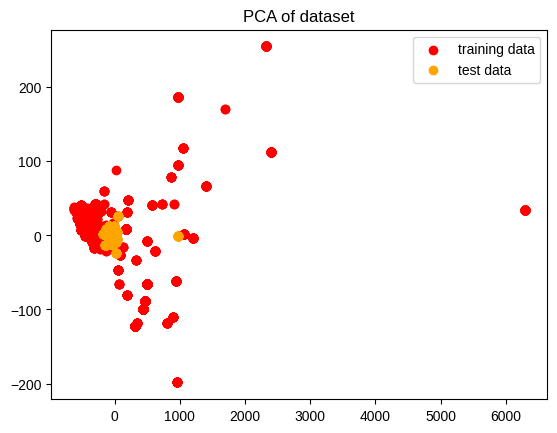

In [17]:
#画出分类图
plt.figure()#创建一个画布
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c="red",label = "training data")
plt.scatter(X_test_pca[:,0],X_test_pca[:,1],c="orange",label = "test data")
plt.legend()#显示图例
plt.title("PCA of dataset")#显示标题
plt.show()

In [18]:
from sklearn.decomposition import PCA
features = ['hydrophobicity', 'aliphatic', 'aromatic', 'sulfur',
        'hydroxyl', 'basic', 'acidic', 'amide', 'polar', 'ionizable',
        'hb_donor', 'hb_acceptor', 'hb_donor_acceptor', 'volume', 'depth', 'sa',
        'enclosure','stability_mean', 'stability_std'] + list(vars()["ligand_ecfp4_fp"].columns)
X_train_pca = PCA(3).fit_transform(df_train_val[features])
X_test_pca = PCA(3).fit_transform(df_test[features])

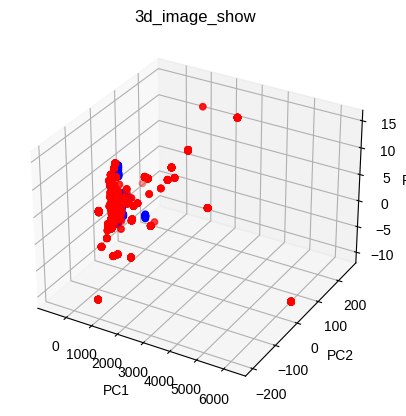

In [36]:
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
ax.set_title('3d_image_show')  # 设置本图名称
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], X_train_pca[:,2], c = 'r',label="traning set")
ax.scatter(X_test_pca[:,0], X_test_pca[:,1], X_test_pca[:,2], c = 'blue',label="test set")# 绘制数据点 c: 'r'红色，'y'黄色，等颜色
 
ax.set_xlabel('PC1')  # 设置x坐标轴
ax.set_ylabel('PC2')  # 设置y坐标轴
ax.set_zlabel('PC3')  # 设置z坐标轴
 
plt.show()
